# Preprocesamiento, PCA e Insights (Titanic)

En esta parte se contemplan los siguinetes ítems:

1) Construccion de hipotesis iniciales.
2) Sintesis de insights.
3) Codificacion de variables categoricas.
4) Escalado/normalizacion de variables numericas.
5) Reduccion de dimensionalidad (PCA).
6) Visualizacion de resultados del preprocesamiento.


In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# --- Configuración general ---
plt.rcParams['figure.figsize'] = (8, 5)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# --- Montar Google Drive ---
drive.mount('/content/drive')

# --- Cambiar directorio a la carpeta donde está el archivo ---
%cd "/content/drive/MyDrive/Colab Notebooks/AnalisisDeDatos/Parcial2"

# --- Cargar el dataset ---
df_raw = pd.read_csv("train.csv")

print("Fuente de datos: train.csv")
print("Tamaño inicial:", df_raw.shape)

# Vista previa de los datos
df_raw.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/AnalisisDeDatos/Parcial2
Fuente de datos: train.csv
Tamaño inicial: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 1) Hipotesis iniciales

- H1: Pclass = 1 tiene mayor supervivencia que Pclass = 2 o 3. (Comparativa)
- H2: Sex = female tiene mayor supervivencia que male. (Comparativa)
- H3: Edades bajas muestran mayor supervivencia sobre clase y sexo. (Relacional)
- H4: Fare se asocia positivamente con la supervivencia. (Correlacional)
- H5: Existen diferencias por Embarked (S, C, Q). (Comparativa)



Tipos de datos:
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Faltantes (%):
 PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            19.87
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
Cabin          77.10
Embarked        0.22
dtype: float64

Describe (numericas):
              count        mean         std   min       25%       50%    75%  \
PassengerId  891.0  446.000000  257.353842  1.00  223.5000  446.0000  668.5   
Survived     891.0    0.383838    0.486592  0.00    0.0000    0.0000    1.0   
Pclass       891.0    2.308642    0.836071  1.00    2.0000    3.0000    3.0   
Age          714.0   29.699118   14.526497  0.42   20.1250   28.0000

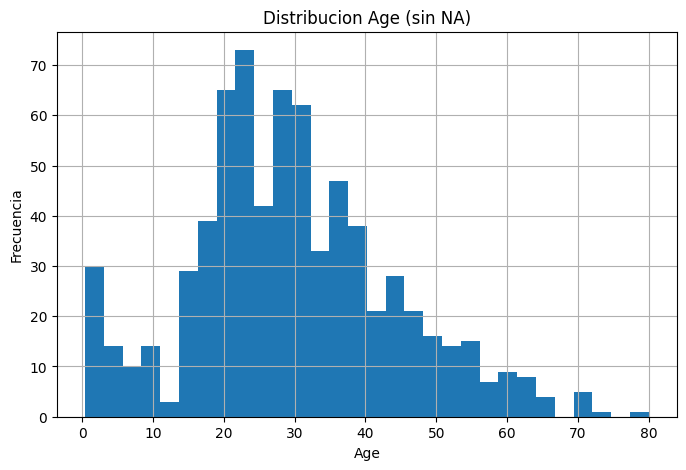

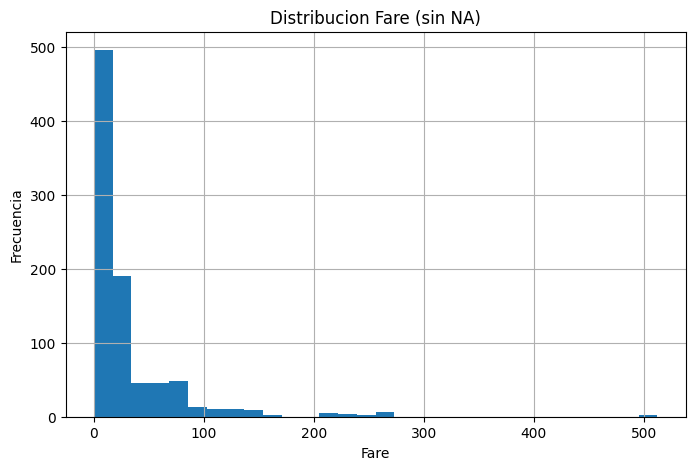

In [ ]:
# EDA breve
print('\nTipos de datos:\n', df_raw.dtypes)
print('\nFaltantes (%):\n', (df_raw.isna().mean()*100).round(2))

num_cols = [c for c in df_raw.columns if df_raw[c].dtype != 'O']
print('\nDescribe (numericas):\n', df_raw[num_cols].describe().T)

if 'Survived' in df_raw.columns:
    print('\nDistribucion Survived:\n', df_raw['Survived'].value_counts(dropna=False))
if set(['Survived','Sex']).issubset(df_raw.columns):
    print('\nTasa de supervivencia por Sex:\n', df_raw.groupby('Sex')['Survived'].mean())
if set(['Survived','Pclass']).issubset(df_raw.columns):
    print('\nTasa de supervivencia por Pclass:\n', df_raw.groupby('Pclass')['Survived'].mean())

if 'Age' in df_raw.columns:
    plt.figure(); df_raw['Age'].dropna().hist(bins=30)
    plt.title('Distribucion Age (sin NA)'); plt.xlabel('Age'); plt.ylabel('Frecuencia'); plt.show()
if 'Fare' in df_raw.columns:
    plt.figure(); df_raw['Fare'].dropna().hist(bins=30)
    plt.title('Distribucion Fare (sin NA)'); plt.xlabel('Fare'); plt.ylabel('Frecuencia'); plt.show()


## 2) Preprocesamiento


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

work_df = df_raw.copy()
target_col = 'Survived' if 'Survived' in work_df.columns else None
base_cols = [c for c in ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked'] if c in work_df.columns]
df = work_df[([target_col] if target_col else []) + base_cols].copy()
print('Columnas en uso:', df.columns.tolist())

if target_col:
    y = df[target_col].copy()
    X = df.drop(columns=[target_col]).copy()
else:
    y = None; X = df.copy()

cat_cols = [c for c in X.columns if X[c].dtype == 'O']
num_cols = [c for c in X.columns if X[c].dtype != 'O']
print('Categoricas:', cat_cols)
print('Numericas:', num_cols)

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

X_num = (pd.DataFrame(num_imputer.fit_transform(X[num_cols]), columns=num_cols, index=X.index)
         if num_cols else pd.DataFrame(index=X.index))
X_cat = (pd.DataFrame(cat_imputer.fit_transform(X[cat_cols]), columns=cat_cols, index=X.index)
         if cat_cols else pd.DataFrame(index=X.index))

if not X_cat.empty:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_cat_ohe = ohe.fit_transform(X_cat)
    ohe_cols = ohe.get_feature_names_out(cat_cols)
    X_cat_enc = pd.DataFrame(X_cat_ohe, columns=ohe_cols, index=X_cat.index)
else:
    X_cat_enc = pd.DataFrame(index=X.index)

X_enc = pd.concat([X_num, X_cat_enc], axis=1)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_enc), columns=X_enc.columns, index=X_enc.index)
print('\nDimension despues de encoding+scaling:', X_scaled.shape)
X_scaled.head()


Columnas en uso: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
Categoricas: ['Sex', 'Embarked']
Numericas: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

Dimension despues de encoding+scaling: (891, 10)


,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.827377,-0.565736,0.432793,-0.473674,-0.502445,-0.737695,0.737695,-0.482043,-0.307562,0.615838
1,-1.566107,0.663861,0.432793,-0.473674,0.786845,1.355574,-1.355574,2.074505,-0.307562,-1.623803
2,0.827377,-0.258337,-0.474545,-0.473674,-0.488854,1.355574,-1.355574,-0.482043,-0.307562,0.615838
3,-1.566107,0.433312,0.432793,-0.473674,0.420730,1.355574,-1.355574,-0.482043,-0.307562,0.615838
4,0.827377,0.433312,-0.474545,-0.473674,-0.486337,-0.737695,0.737695,-0.482043,-0.307562,0.615838


### Visualizacion de resultados del preprocesamiento


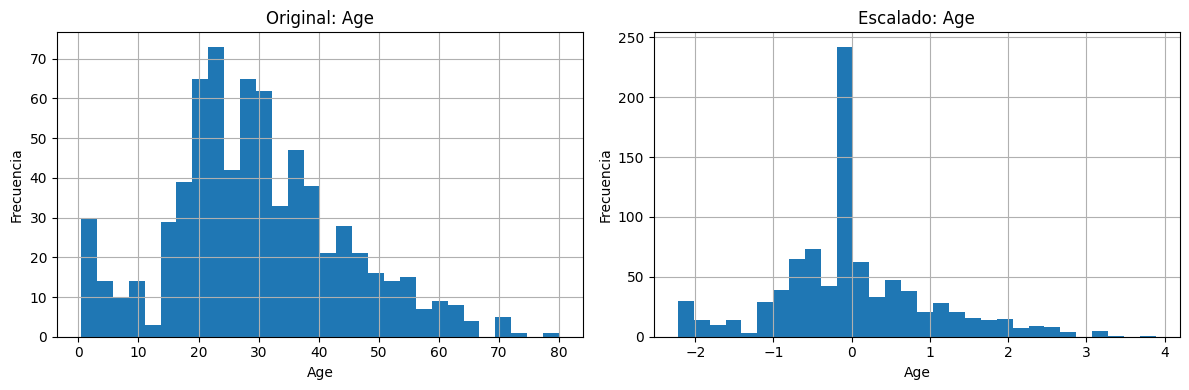

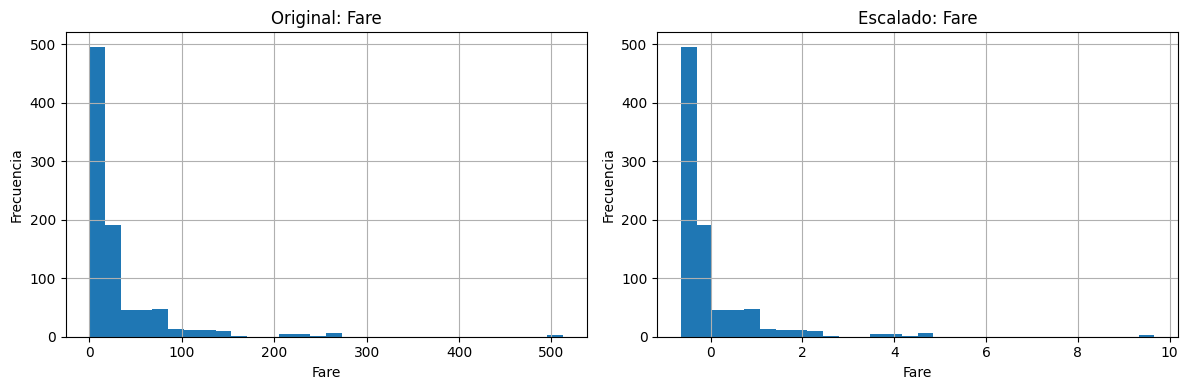

In [ ]:
def compare_hist(original, scaled, col, bins=30):
    fig = plt.figure(figsize=(12,4))
    ax1 = plt.subplot(1,2,1); original[col].dropna().hist(bins=bins)
    ax1.set_title(f'Original: {col}'); ax1.set_xlabel(col); ax1.set_ylabel('Frecuencia')
    ax2 = plt.subplot(1,2,2); scaled[col].dropna().hist(bins=bins)
    ax2.set_title(f'Escalado: {col}'); ax2.set_xlabel(col); ax2.set_ylabel('Frecuencia')
    plt.tight_layout(); plt.show()

for c in ['Age','Fare']:
    if c in df.columns and c in X_scaled.columns:
        compare_hist(df, X_scaled, c)


## 3) Reduccion de dimensionalidad (PCA)


Varianza explicada por componente: [0.2479778  0.19668335]
Varianza explicada acumulada: [0.2479778  0.44466115]


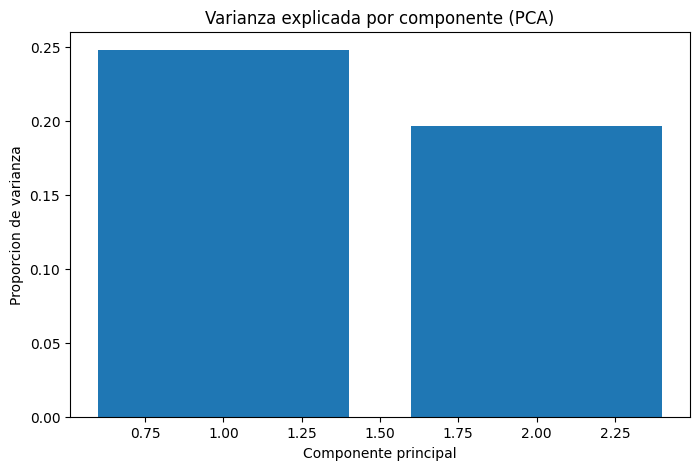

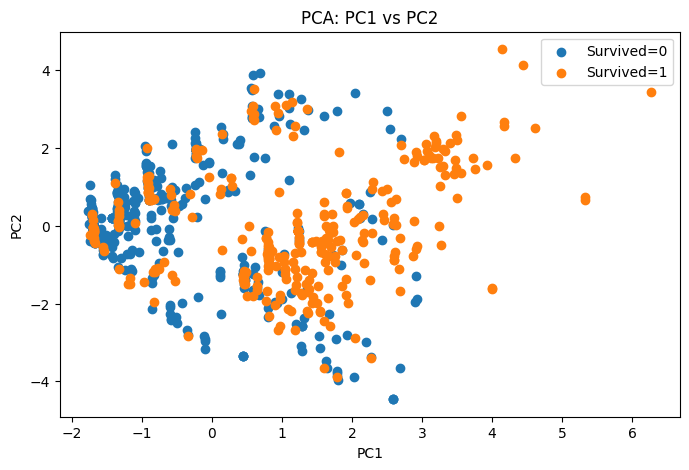

In [ ]:
from sklearn.decomposition import PCA

n_comp = 2
pca = PCA(n_components=n_comp, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
print('Varianza explicada por componente:', pca.explained_variance_ratio_)
print('Varianza explicada acumulada:', pca.explained_variance_ratio_.cumsum())

plt.figure(); plt.bar(range(1, n_comp+1), pca.explained_variance_ratio_)
plt.title('Varianza explicada por componente (PCA)')
plt.xlabel('Componente principal'); plt.ylabel('Proporcion de varianza'); plt.show()

plt.figure()
if 'Survived' in df_raw.columns and y is not None:
    survived_vals = y.values
    mask0 = survived_vals == 0
    mask1 = survived_vals == 1
    plt.scatter(X_pca[mask0,0], X_pca[mask0,1], label='Survived=0')
    plt.scatter(X_pca[mask1,0], X_pca[mask1,1], label='Survived=1')
    plt.legend()
else:
    plt.scatter(X_pca[:,0], X_pca[:,1])
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA: PC1 vs PC2'); plt.show()


## 4) Sintesis de insights


In [ ]:
insights = []
if 'Age' in df_raw.columns:
    insights.append(f"Faltantes en Age: {(df_raw['Age'].isna().mean()*100):.2f}%")
if 'Embarked' in df_raw.columns:
    insights.append(f"Faltantes en Embarked: {(df_raw['Embarked'].isna().mean()*100):.2f}%")
if 'Cabin' in df_raw.columns:
    insights.append(f"Faltantes en Cabin: {(df_raw['Cabin'].isna().mean()*100):.2f}% (alto)")
if set(['Survived','Sex']).issubset(df_raw.columns):
    g = df_raw.groupby('Sex')['Survived'].mean()
    if 'female' in g.index and 'male' in g.index:
        insights.append(f"Supervivencia Female: {g['female']:.2f}, Male: {g['male']:.2f}")
if set(['Survived','Pclass']).issubset(df_raw.columns):
    gp = df_raw.groupby('Pclass')['Survived'].mean().sort_index()
    insights.append('Supervivencia por Pclass: ' + ', '.join([f"{int(k)}={v:.2f}" for k,v in gp.items()]))
if 'Fare' in df_raw.columns:
    skew = df_raw['Fare'].dropna().skew()
    insights.append(f"Skew de Fare: {skew:.2f}")
if set(['Survived','Embarked']).issubset(df_raw.columns):
    ge = df_raw.groupby('Embarked')['Survived'].mean()
    insights.append('Supervivencia por Embarked: ' + ', '.join([f"{k}={v:.2f}" for k,v in ge.items()]))
if len(insights) < 5 and 'Age' in df_raw.columns and 'Survived' in df_raw.columns:
    import pandas as pd
    try:
        q = pd.qcut(df_raw['Age'], 4, duplicates='drop')
        ga = df_raw.groupby(q)['Survived'].mean()
        insights.append('Supervivencia por cuartiles de Age: ' + ', '.join([f"{k}={v:.2f}" for k,v in ga.items()]))
    except Exception:
        pass
print('\nHallazgos relevantes:')
for i, s in enumerate(insights, 1):
    print(f"{i}. {s}")



Hallazgos relevantes:
1. Faltantes en Age: 19.87%
2. Faltantes en Embarked: 0.22%
3. Faltantes en Cabin: 77.10% (alto)
4. Supervivencia Female: 0.74, Male: 0.19
5. Supervivencia por Pclass: 1=0.63, 2=0.47, 3=0.24
6. Skew de Fare: 4.79
7. Supervivencia por Embarked: C=0.55, Q=0.39, S=0.34


## 5) Artefactos exportados


In [ ]:
from pathlib import Path
out_dir = Path('outputs'); out_dir.mkdir(exist_ok=True)
X_scaled.to_csv(out_dir / 'X_procesado_escalado.csv', index=False)
if 'Survived' in df_raw.columns:
    df_raw['Survived'].to_csv(out_dir / 'y_target.csv', index=False)
import pandas as pd
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
if 'Survived' in df_raw.columns:
    pca_df['Survived'] = df_raw['Survived'].values
pca_df.to_csv(out_dir / 'PCA_2D.csv', index=False)
print('Archivos guardados en:', out_dir.resolve())
print('- X_procesado_escalado.csv')
print('- y_target.csv')
print('- PCA_2D.csv')


Archivos guardados en: /content/drive/MyDrive/Colab Notebooks/AnalisisDeDatos/Parcial2/outputs
- X_procesado_escalado.csv
- y_target.csv
- PCA_2D.csv
